# Pairs Trading — Single Notebook Project

This notebook is a **self-contained** pairs-trading pipeline:
- Load prices (Yahoo Finance)
- Estimate hedge ratio & test cointegration (Engle–Granger)
- Build a z-score mean-reversion strategy
- Backtest with delay, costs, slippage, borrow fee
- Report metrics & plot results
- Optional sensitivity analysis

> Keep logic here for simplicity; refactor to modules later if it grows.
## Setup & Reproducibility

We keep **all parameters in one config** so experiments are repeatable.
Switch to your own tickers or CSVs in one place. Keep costs honest.


In [11]:
# Import utility functions from modules
import sys, os
repo_root = os.path.dirname(os.getcwd())  
sys.path.append(repo_root)

import src.data_loader as dl
from importlib import reload; reload(dl)
from src.metrics import sharpe_ratio, sortino_ratio, max_drawdown, annual_return, hit_rate

# Core imports
from __future__ import annotations
from dataclasses import dataclass
from typing import Optional, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

CONFIG = {
    "data": {
        "source": "yfinance",       
        "ticker1": "XOM",
        "ticker2": "CVX",
        "csv1": None,                
        "csv2": None,                
        "start": "2018-01-01",
        "end": None,
        "price_col": "Adj Close",
        "freq": "B",                 
    },
    "strategy": {
        "lookback": 60,
        "entry": 2.0,
        "exit": 0.0,
        "max_abs_z": 4.0,            
        "cooldown": 2,               
    },
    "execution": {
        "tc_bps": 1.0,
        "slippage_bps": 0.5,
        "short_borrow_apr": 0.02,
        "capital": 1_000_000.0,
        "signal_delay": 1,          
        "periods_per_year": 252
    }
}

## Data Loading & Alignment

We need **synchronized** series (same dates) to avoid spurious signals.  
We:
- Pull from Yahoo or load CSVs
- Align to **business days**
- **Forward-fill** to bridge holidays/missing prints (common for ETFs vs stocks)


Loading price data...
tickers: XOM CVX
csvs   : None None


/Users/corinnama/Desktop/Quant Repo/quant-project-starters/pairs-trading-stat-arb/src/data_loader.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  """
[*********************100%***********************]  2 of 2 completed


Loaded 2009 days of data from 2018-01-02 to 2025-09-12
Tickers: XOM vs CVX
Data shape: (2009, 2)
Missing values: 0

Price Statistics:
Ticker            A            B
count   2009.000000  2009.000000
mean      73.127685   112.850960
std       27.474299    31.801592
min       24.356321    42.442684
25%       52.369537    86.779083
50%       60.320431    97.105286
75%      101.356842   144.400620
max      120.995155   167.402100


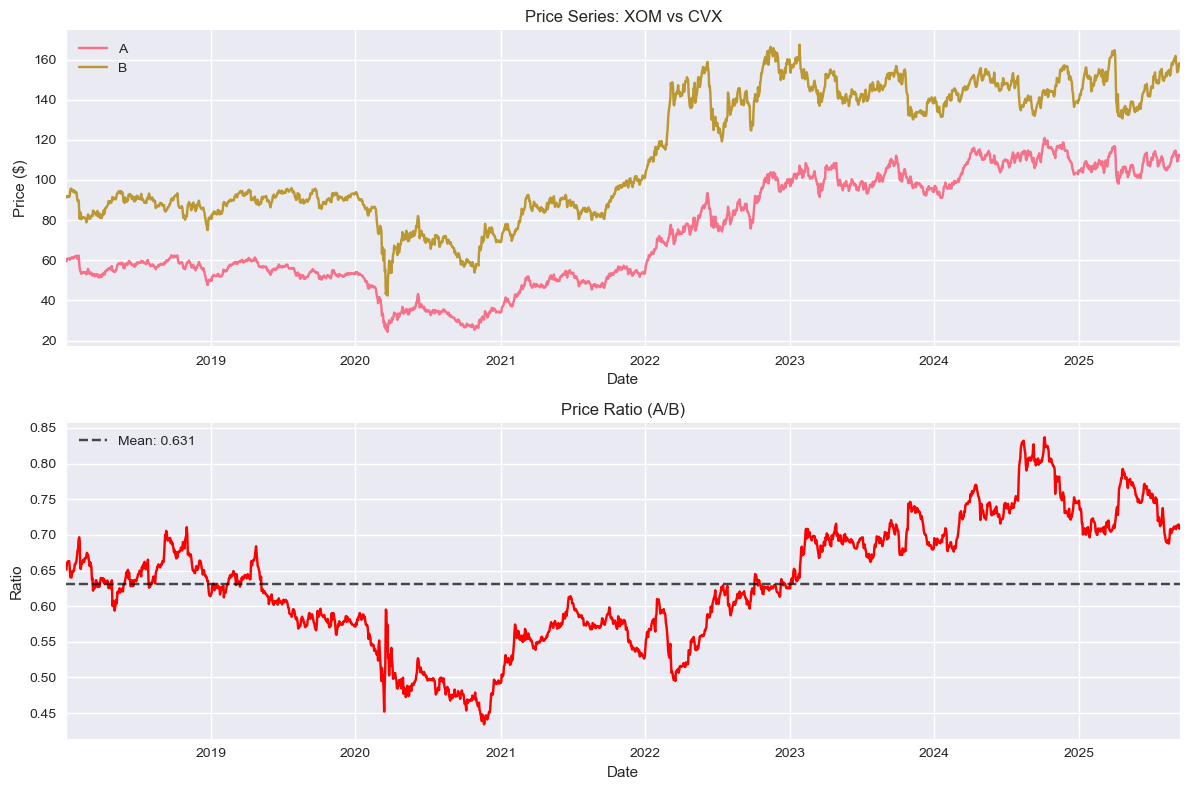

In [13]:
# Load data using the module function
print("Loading price data...")

CONFIG["data"].update({
    "ticker1": "XOM",
    "ticker2": "CVX",
    "csv1": None,
    "csv2": None,
})

d = CONFIG["data"]
print("tickers:", d.get("ticker1"), d.get("ticker2"))
print("csvs   :", d.get("csv1"), d.get("csv2"))

prices = dl.get_prices(CONFIG["data"])
print(f"Loaded {len(prices)} days of data from {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"Tickers: {CONFIG['data']['ticker1']} vs {CONFIG['data']['ticker2']}")
print(f"Data shape: {prices.shape}")
print(f"Missing values: {prices.isnull().sum().sum()}")

# Display basic statistics
print("\nPrice Statistics:")
print(prices.describe())

# Quick visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Price series
prices.plot(ax=ax1, title=f"Price Series: {CONFIG['data']['ticker1']} vs {CONFIG['data']['ticker2']}")
ax1.set_ylabel("Price ($)")
ax1.legend()

# Price ratio
ratio = prices["A"] / prices["B"]
ratio.plot(ax=ax2, title="Price Ratio (A/B)", color='red')
ax2.set_ylabel("Ratio")
ax2.axhline(y=ratio.mean(), color='black', linestyle='--', alpha=0.7, label=f'Mean: {ratio.mean():.3f}')
ax2.legend()

plt.tight_layout()
plt.show()

## Hedge Ratio & Cointegration (Engle–Granger)

1) Regress `A_t` on `B_t` → `A_t = α + β B_t + ε_t`  
   β is the **hedge ratio** (how many B to offset A).  
2) Test residuals `ε_t` with **ADF** (Augmented Dickey–Fuller).  
   If residuals are **stationary** (p-value small), A and B are likely **cointegrated**.

**Interpretation tips**
- **β** close to economic intuition? (e.g., two oil majors → β ~ 1)  
- **ADF p-value** < 0.05 is a common heuristic (not a guarantee).  
- Check **R²** and **residual σ**: tighter residuals usually give cleaner signals.


Running Engle-Granger cointegration test...

📊 Cointegration Results:
Hedge ratio (β): 0.8299
ADF p-value: 0.0297
ADF statistic: -3.0601
R²: 0.9229
Residual std: 7.6296

✅ Cointegration detected! (p < 0.05)
   The pair appears to be cointegrated with hedge ratio 0.830


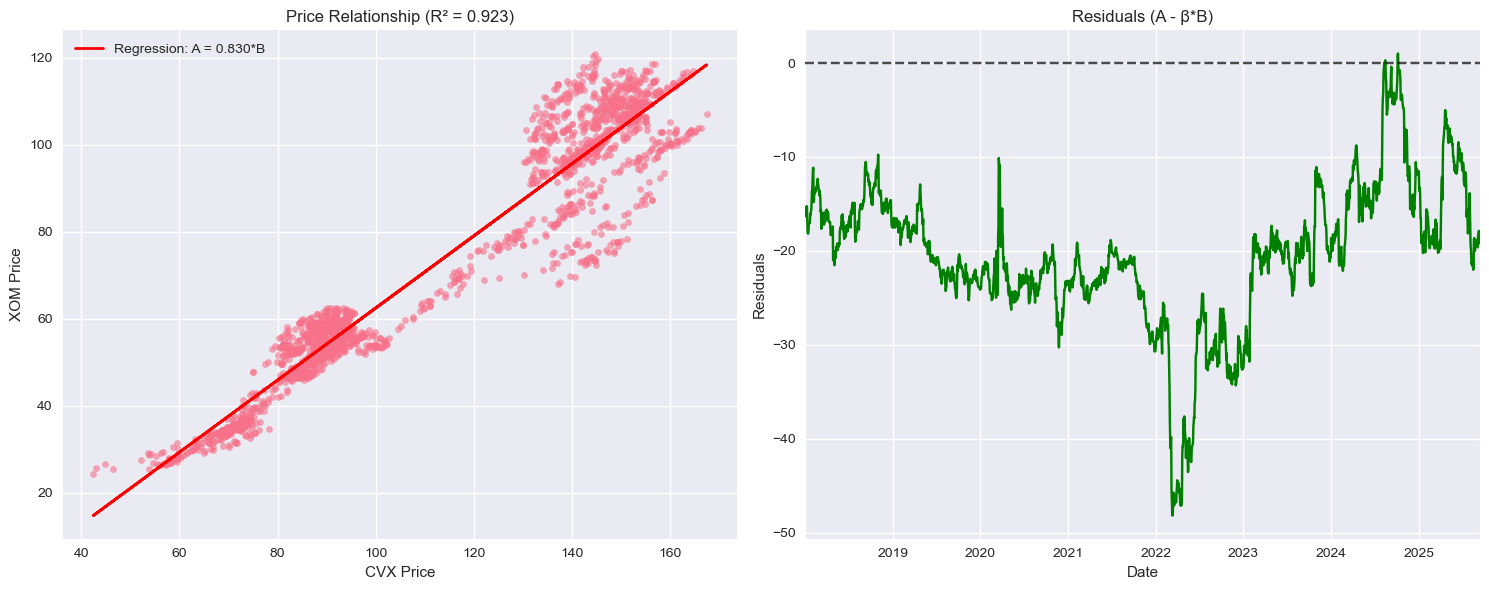

In [15]:
# Core cointegration functions (educational implementation)
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

@dataclass
class CointResult:
    """Results from Engle-Granger cointegration test"""
    beta: float
    pval: float
    adf_stat: float
    r2: float
    resid_std: float

def hedge_ratio_ols(df: pd.DataFrame) -> float:
    """
    Calculate hedge ratio using OLS regression: A = α + β*B + ε
    
    Returns:
        float: Hedge ratio (β) - how many units of B to hedge one unit of A
    """
    A = df["A"].values
    B = sm.add_constant(df["B"].values)
    res = sm.OLS(A, B).fit()
    return float(res.params[1])

def engle_granger(df: pd.DataFrame) -> CointResult:
    """
    Perform Engle-Granger 2-step cointegration test:
    1. OLS regression: A = α + β*B + ε
    2. ADF test on residuals ε
    
    Returns:
        CointResult: Cointegration test results
    """
    A = df["A"]
    B = sm.add_constant(df["B"])
    ols = sm.OLS(A, B).fit()
    resid = ols.resid
    adf_stat, pval, *_ = adfuller(resid, autolag="AIC")
    
    return CointResult(
        beta=float(ols.params.iloc[1]),
        pval=float(pval),
        adf_stat=float(adf_stat),
        r2=float(ols.rsquared),
        resid_std=float(resid.std(ddof=1)),
    )

# Run cointegration analysis
print("Running Engle-Granger cointegration test...")
eg_result = engle_granger(prices)

print(f"\n📊 Cointegration Results:")
print(f"Hedge ratio (β): {eg_result.beta:.4f}")
print(f"ADF p-value: {eg_result.pval:.4f}")
print(f"ADF statistic: {eg_result.adf_stat:.4f}")
print(f"R²: {eg_result.r2:.4f}")
print(f"Residual std: {eg_result.resid_std:.4f}")

# Interpretation
if eg_result.pval < 0.05:
    print(f"\n✅ Cointegration detected! (p < 0.05)")
    print(f"   The pair appears to be cointegrated with hedge ratio {eg_result.beta:.3f}")
else:
    print(f"\n❌ No cointegration detected (p ≥ 0.05)")
    print(f"   The pair may not be suitable for pairs trading")

# Visualize the relationship
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot with regression line
ax1.scatter(prices["B"], prices["A"], alpha=0.6, s=20)
ax1.plot(prices["B"], eg_result.beta * prices["B"] + (prices["A"] - eg_result.beta * prices["B"]).mean(), 
         'r-', linewidth=2, label=f'Regression: A = {eg_result.beta:.3f}*B')
ax1.set_xlabel(f"{CONFIG['data']['ticker2']} Price")
ax1.set_ylabel(f"{CONFIG['data']['ticker1']} Price")
ax1.set_title(f"Price Relationship (R² = {eg_result.r2:.3f})")
ax1.legend()

# Residuals plot
residuals = prices["A"] - eg_result.beta * prices["B"]
residuals.plot(ax=ax2, title="Residuals (A - β*B)", color='green')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax2.set_ylabel("Residuals")

plt.tight_layout()
plt.show()

## Spread, Z-Score & Trading Logic

- **Spread**: `S_t = A_t − β B_t`  
- **Z-score**: `(S_t − μ) / σ` on a rolling window (mean-reversion proxy)

**Trading rule (hysteresis)**
- Enter **long spread** (+1): z ≤ −entry  → buy A, short β·B  
- Enter **short spread** (−1): z ≥ +entry → short A, buy β·B  
- Exit when |z| ≤ exit  
- Optional **emergency stop**: |z| ≥ max_abs_z  
- Optional **cool-down**: pause after exit to avoid churn


Generating trading signals...

📈 Signal Statistics:
Total signals: 881
Long signals: 393
Short signals: 488
Signal frequency: 43.85%


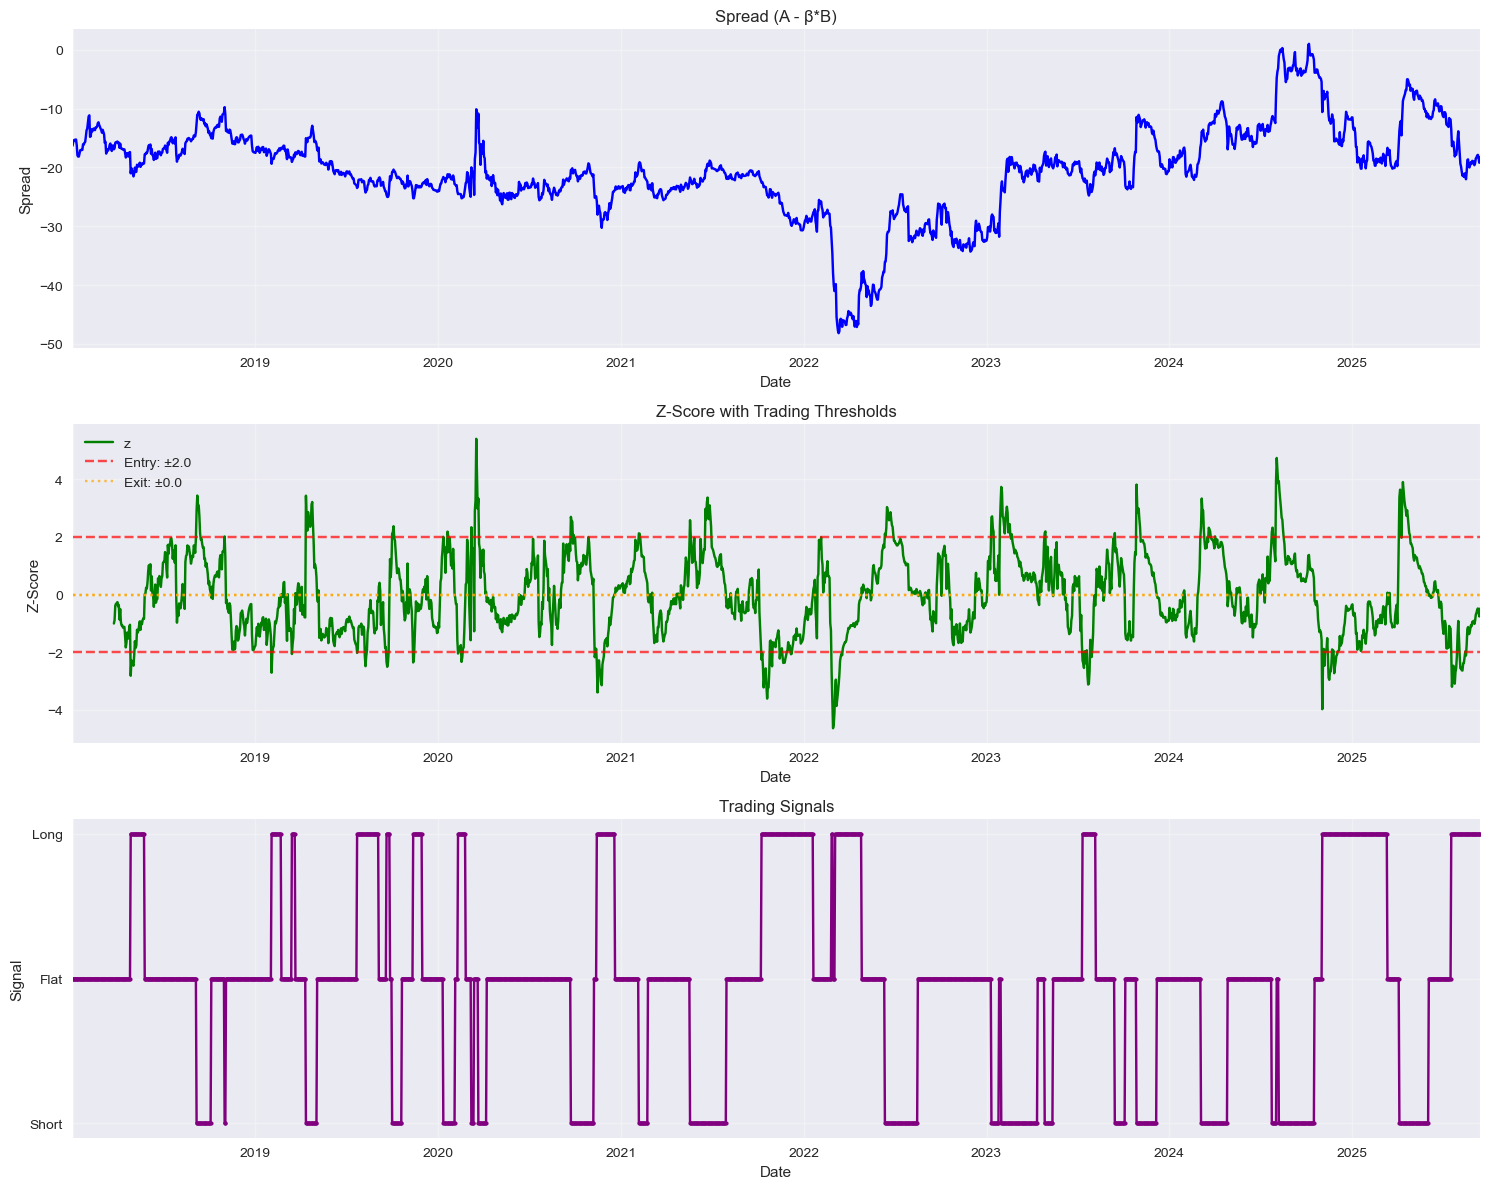

In [17]:
# Signal generation functions (educational implementation)
def compute_spread(df: pd.DataFrame, beta: float) -> pd.Series:
    """
    Compute the spread: S_t = A_t - β*B_t
    
    Args:
        df: DataFrame with columns 'A' and 'B'
        beta: Hedge ratio
        
    Returns:
        pd.Series: Spread series
    """
    return (df["A"] - beta * df["B"]).rename("spread")

def zscore(series: pd.Series, lookback: int = 60) -> pd.Series:
    """
    Calculate rolling z-score: (S_t - μ_t) / σ_t
    
    Args:
        series: Input series
        lookback: Rolling window size
        
    Returns:
        pd.Series: Z-score series
    """
    m = series.rolling(lookback).mean()
    s = series.rolling(lookback).std()
    return ((series - m) / s).rename("z")

def generate_signals(
    z: pd.Series,
    entry: float = 2.0,
    exit: float = 0.0,
    max_abs_z: float | None = None,
    cooldown: int = 0,
) -> pd.Series:
    """
    Generate trading signals with hysteresis to avoid whipsawing
    
    Args:
        z: Z-score series
        entry: Entry threshold (absolute value)
        exit: Exit threshold (absolute value)
        max_abs_z: Emergency stop threshold
        cooldown: Days to wait after exit before re-entering
        
    Returns:
        pd.Series: Signals (-1, 0, +1)
    """
    z = z.copy()
    pos = np.zeros(len(z), dtype=float)
    cd = 0  # cooldown counter
    
    for i in range(1, len(z)):
        prev = pos[i-1]

        # Handle cooldown period
        if cd > 0:
            pos[i] = 0.0
            cd -= 1
            continue

        zi = z.iloc[i]
        if np.isnan(zi):
            pos[i] = 0.0
            continue

        # Emergency stop if z-score is too extreme
        if max_abs_z is not None and abs(zi) >= max_abs_z:
            pos[i] = 0.0
            cd = cooldown
            continue

        # Signal generation logic
        if prev == 0:  # No position
            if zi <= -entry:
                pos[i] = +1  # Long spread
            elif zi >= +entry:
                pos[i] = -1  # Short spread
            else:
                pos[i] = 0
        elif prev == +1:  # Long position
            pos[i] = 0 if zi >= exit else +1
        elif prev == -1:  # Short position
            pos[i] = 0 if zi <= -exit else -1

        # Enter cooldown after exit
        if prev != 0 and pos[i] == 0 and cooldown > 0:
            cd = cooldown

    return pd.Series(pos, index=z.index, name="signal")

# Generate signals
print("Generating trading signals...")
spread = compute_spread(prices, eg_result.beta)
z_scores = zscore(spread, CONFIG["strategy"]["lookback"])
signals = generate_signals(
    z_scores,
    entry=CONFIG["strategy"]["entry"],
    exit=CONFIG["strategy"]["exit"],
    max_abs_z=CONFIG["strategy"]["max_abs_z"],
    cooldown=CONFIG["strategy"]["cooldown"]
)

print(f"\n📈 Signal Statistics:")
print(f"Total signals: {(signals != 0).sum()}")
print(f"Long signals: {(signals == 1).sum()}")
print(f"Short signals: {(signals == -1).sum()}")
print(f"Signal frequency: {(signals != 0).mean():.2%}")

# Visualize signals
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Spread
spread.plot(ax=ax1, title="Spread (A - β*B)", color='blue')
ax1.set_ylabel("Spread")
ax1.grid(True, alpha=0.3)

# Z-scores with thresholds
z_scores.plot(ax=ax2, title="Z-Score with Trading Thresholds", color='green')
ax2.axhline(CONFIG["strategy"]["entry"], linestyle="--", color='red', alpha=0.7, label=f'Entry: ±{CONFIG["strategy"]["entry"]}')
ax2.axhline(-CONFIG["strategy"]["entry"], linestyle="--", color='red', alpha=0.7)
ax2.axhline(CONFIG["strategy"]["exit"], linestyle=":", color='orange', alpha=0.7, label=f'Exit: ±{CONFIG["strategy"]["exit"]}')
ax2.axhline(-CONFIG["strategy"]["exit"], linestyle=":", color='orange', alpha=0.7)
ax2.set_ylabel("Z-Score")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Signals
signals.plot(ax=ax3, title="Trading Signals", color='purple', marker='o', markersize=3)
ax3.set_ylabel("Signal")
ax3.set_xlabel("Date")
ax3.set_yticks([-1, 0, 1])
ax3.set_yticklabels(['Short', 'Flat', 'Long'])
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Backtester — Assumptions & Frictions

- **Dollar-neutral**: each leg targets ~50% of capital  
- **No look-ahead**: apply **signal_delay** (trade next bar)  
- **Costs**: transaction cost + slippage (bps) on traded notional  
- **Borrow fee**: daily accrual on short leg notional (APR / 252)  
- Optional **max gross** cap if you extend sizing

> 👀 **Read this before trusting numbers**: If your z-score looks great but PnL dies once costs are added,
the edge may be too thin or the pair not truly stationary.


In [19]:
# Backtesting class (educational implementation)
class PairsBacktester:
    """
    Realistic backtester for pairs trading strategy with:
    - Transaction costs and slippage
    - Short borrow fees
    - Signal delay to avoid look-ahead bias
    - Dollar-neutral positioning
    """
    
    def __init__(self, tc_bps: float = 1.0, slippage_bps: float = 0.5,
                 short_borrow_apr: float = 0.02, capital: float = 1_000_000.0,
                 signal_delay: int = 1, periods_per_year: int = 252,
                 max_gross: float | None = None):
        self.tc_bps = float(tc_bps)
        self.slippage_bps = float(slippage_bps)
        self.short_borrow_apr = float(short_borrow_apr)
        self.capital = float(capital)
        self.signal_delay = int(signal_delay)
        self.ppy = int(periods_per_year)
        self.max_gross = max_gross

    def _shares(self, prices: pd.DataFrame, signal: pd.Series, beta: float) -> pd.DataFrame:
        """Calculate position sizes with signal delay"""
        prices = prices[["A","B"]].copy()
        sig = signal.reindex(prices.index).fillna(0.0)
        
        # Apply signal delay to avoid look-ahead bias
        if self.signal_delay > 0:
            sig = sig.shift(self.signal_delay).fillna(0.0)

        # Dollar-neutral positioning: 50% capital per leg
        gross_leg = self.capital * 0.5
        A_shares = (gross_leg / prices["A"]) * sig
        B_shares = -(gross_leg / prices["B"]) * beta * sig

        shares = pd.DataFrame({"A_shares": A_shares, "B_shares": B_shares})
        
        # Optional gross exposure cap
        if self.max_gross is not None:
            gross_now = (shares.abs().mul(prices.to_numpy())).sum(axis=1)
            scale = np.minimum(1.0, self.max_gross / np.maximum(gross_now, 1e-9))
            shares = shares.mul(scale, axis=0)
            
        return shares

    def simulate(self, prices: pd.DataFrame, signal: pd.Series, beta: float) -> dict:
        """
        Run the backtest simulation
        
        Returns:
            dict: Backtest results with PnL, equity, costs, etc.
        """
        prices = prices.dropna().copy()
        shares = self._shares(prices, signal, beta)
        trades = shares.diff().fillna(0.0).rename(columns={"A_shares":"A_trades","B_shares":"B_trades"})

        # Price changes
        dA = prices["A"].diff().fillna(0.0)
        dB = prices["B"].diff().fillna(0.0)

        # Position PnL (using previous day's positions)
        pos_prev = shares.shift(1).fillna(0.0)
        pnl_pos = pos_prev["A_shares"] * dA + pos_prev["B_shares"] * dB

        # Trading costs (transaction cost + slippage)
        traded_notional = (trades.abs().assign(
            A=lambda x: x["A_trades"] * prices["A"],
            B=lambda x: x["B_trades"] * prices["B"]
        )[["A","B"]].sum(axis=1))
        cost_rate = (self.tc_bps + self.slippage_bps) / 10_000.0
        costs = traded_notional * cost_rate

        # Short borrow fees
        short_notional = (pos_prev["B_shares"].clip(upper=0).abs() * prices["B"])
        borrow_daily = short_notional * (self.short_borrow_apr / self.ppy)

        # Net PnL
        pnl = pnl_pos - costs - borrow_daily
        equity = pnl.cumsum()

        return {
            "pnl": pnl.rename("pnl"),
            "equity": equity.rename("equity"),
            "costs": costs.rename("costs"),
            "borrow": borrow_daily.rename("borrow_fee"),
            "A_shares": shares["A_shares"],
            "B_shares": shares["B_shares"],
            "A_trades": trades["A_trades"],
            "B_trades": trades["B_trades"],
        }

# Run backtest
print("Running backtest simulation...")
backtester = PairsBacktester(**CONFIG["execution"])
results = backtester.simulate(prices, signals, eg_result.beta)

print(f"\n💰 Backtest Configuration:")
print(f"Capital: ${CONFIG['execution']['capital']:,.0f}")
print(f"Transaction costs: {CONFIG['execution']['tc_bps']} bps")
print(f"Slippage: {CONFIG['execution']['slippage_bps']} bps")
print(f"Short borrow rate: {CONFIG['execution']['short_borrow_apr']:.1%} APR")
print(f"Signal delay: {CONFIG['execution']['signal_delay']} day(s)")

# Calculate performance metrics
cap = CONFIG["execution"]["capital"]
sharpe = sharpe_ratio(results["pnl"], capital=cap)
sortino = sortino_ratio(results["pnl"], capital=cap)
ann_ret = annual_return(results["pnl"], capital=cap)
max_dd = max_drawdown(results["equity"])
hit_rate_val = hit_rate(results["pnl"])

print(f"\n📊 Performance Results:")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Annual Return: {ann_ret:.2%}")
print(f"Max Drawdown: ${max_dd:,.0f}")
print(f"Hit Rate: {hit_rate_val:.2%}")

# Cost analysis
total_costs = results["costs"].sum()
total_borrow = results["borrow"].sum()
total_pnl = results["pnl"].sum()

print(f"\n💸 Cost Breakdown:")
print(f"Total transaction costs: ${total_costs:,.0f}")
print(f"Total borrow fees: ${total_borrow:,.0f}")
print(f"Total costs: ${total_costs + total_borrow:,.0f}")
print(f"Costs as % of PnL: {abs(total_costs + total_borrow) / abs(total_pnl) * 100:.1f}%")


Running backtest simulation...

💰 Backtest Configuration:
Capital: $1,000,000
Transaction costs: 1.0 bps
Slippage: 0.5 bps
Short borrow rate: 2.0% APR
Signal delay: 1 day(s)

📊 Performance Results:
Sharpe Ratio: 0.51
Sortino Ratio: 0.49
Annual Return: 2.61%
Max Drawdown: $-108,355
Hit Rate: 22.15%

💸 Cost Breakdown:
Total transaction costs: $10,610
Total borrow fees: $12,878
Total costs: $23,488
Costs as % of PnL: 11.3%


## Metrics — Reading the scoreboard

- **Sharpe**: risk-adjusted return (sensitive to tails)  
- **Sortino**: penalizes **downside** volatility only  
- **Annual return**: average daily PnL ÷ capital × 252  
- **Max drawdown**: worst cumulative dip in dollars  
- **Hit rate**: fraction of positive PnL days (not the same as profitability!)


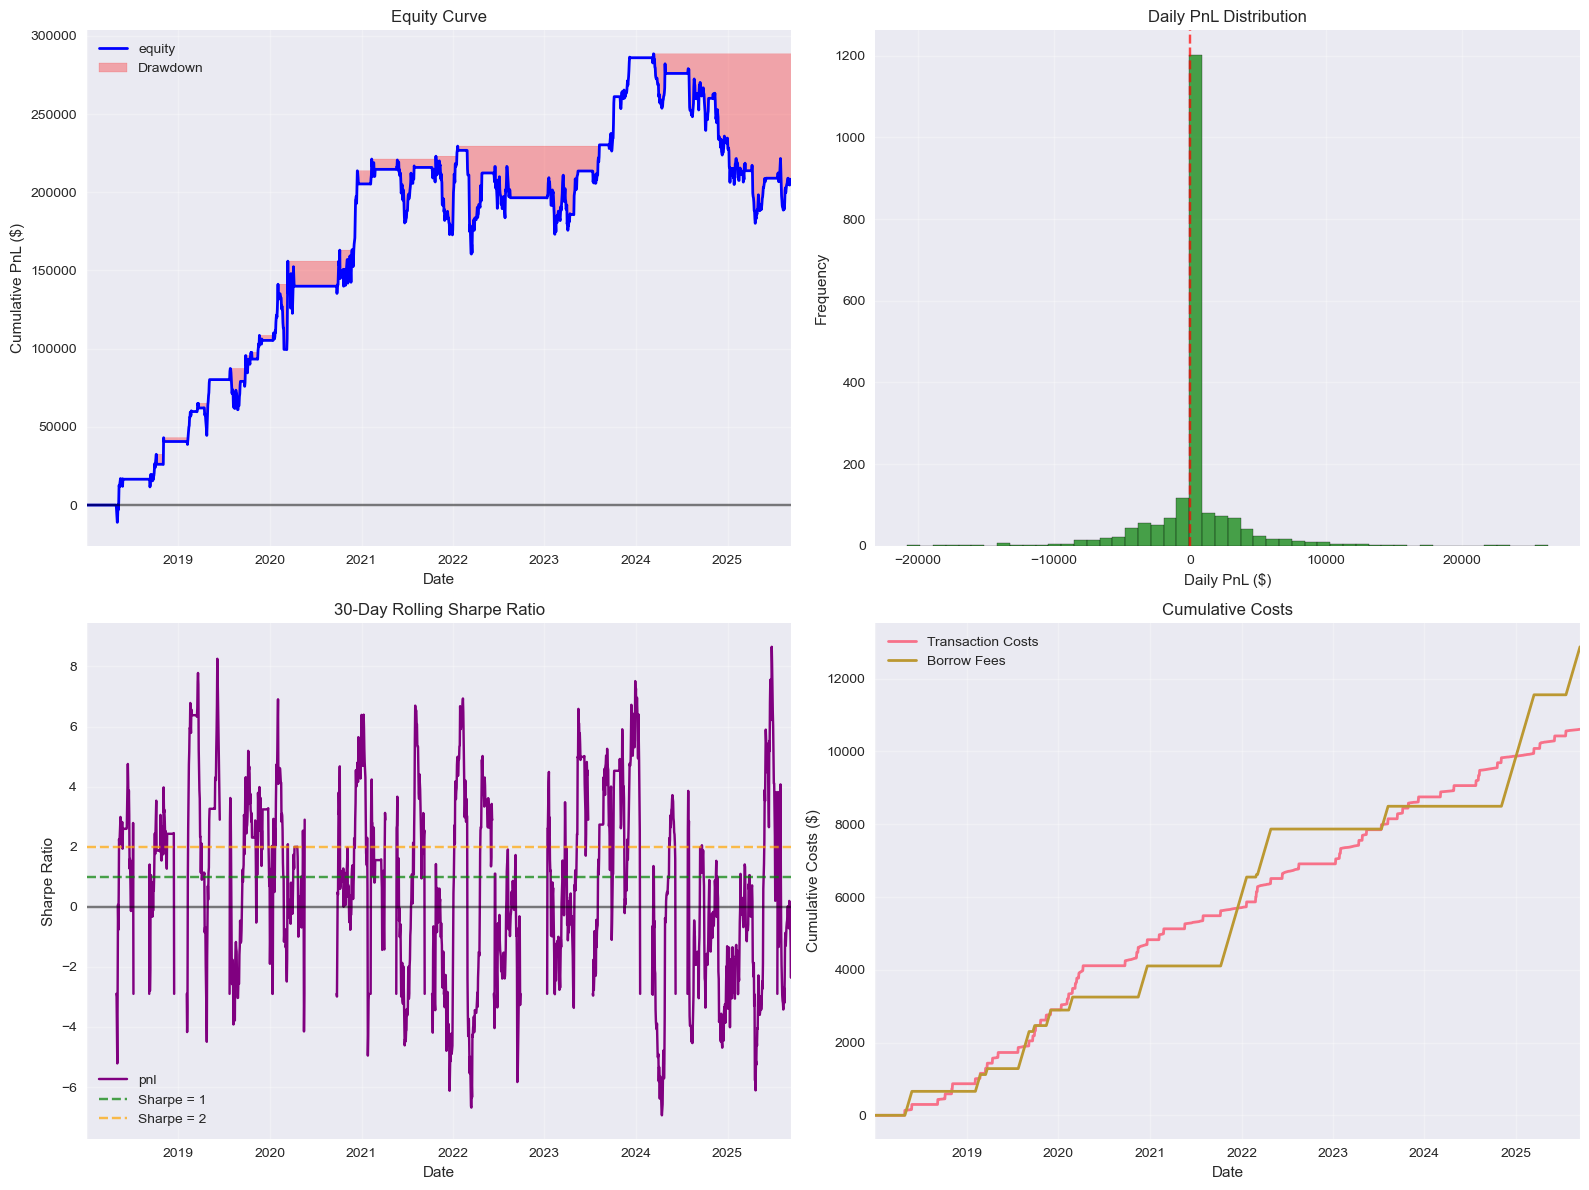


📋 Performance Summary:
Metric                    Value           Interpretation
Sharpe Ratio              0.51            Fair
Sortino Ratio             0.49            Poor
Annual Return             2.61%           Poor
Max Drawdown              $-108,355       Fair
Hit Rate                  22.15%          Poor


In [21]:
# Comprehensive performance visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Equity curve
results["equity"].plot(ax=ax1, title="Equity Curve", color='blue', linewidth=2)
ax1.set_ylabel("Cumulative PnL ($)")
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add drawdown shading
roll_max = results["equity"].cummax()
drawdown = results["equity"] - roll_max
ax1.fill_between(results["equity"].index, results["equity"], roll_max, 
                 where=(drawdown < 0), color='red', alpha=0.3, label='Drawdown')
ax1.legend()

# 2. Daily PnL distribution
results["pnl"].hist(bins=50, ax=ax2, alpha=0.7, color='green', edgecolor='black')
ax2.set_title("Daily PnL Distribution")
ax2.set_xlabel("Daily PnL ($)")
ax2.set_ylabel("Frequency")
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax2.grid(True, alpha=0.3)

# 3. Rolling Sharpe ratio (30-day window)
rolling_returns = results["pnl"] / cap
rolling_sharpe = rolling_returns.rolling(30).mean() / rolling_returns.rolling(30).std() * np.sqrt(252)
rolling_sharpe.plot(ax=ax3, title="30-Day Rolling Sharpe Ratio", color='purple')
ax3.set_ylabel("Sharpe Ratio")
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Sharpe = 1')
ax3.axhline(y=2, color='orange', linestyle='--', alpha=0.7, label='Sharpe = 2')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Costs breakdown
costs_data = pd.DataFrame({
    'Transaction Costs': results["costs"].cumsum(),
    'Borrow Fees': results["borrow"].cumsum()
})
costs_data.plot(ax=ax4, title="Cumulative Costs", linewidth=2)
ax4.set_ylabel("Cumulative Costs ($)")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance summary table
print("\n📋 Performance Summary:")
print("=" * 50)
print(f"{'Metric':<25} {'Value':<15} {'Interpretation'}")
print("=" * 50)
print(f"{'Sharpe Ratio':<25} {sharpe:<15.2f} {'Good' if sharpe > 1 else 'Poor' if sharpe < 0.5 else 'Fair'}")
print(f"{'Sortino Ratio':<25} {sortino:<15.2f} {'Good' if sortino > 1 else 'Poor' if sortino < 0.5 else 'Fair'}")
print(f"{'Annual Return':<25} {ann_ret:<15.2%} {'Good' if ann_ret > 0.1 else 'Poor' if ann_ret < 0.05 else 'Fair'}")
print(f"{'Max Drawdown':<25} ${max_dd:<14,.0f} {'Good' if abs(max_dd) < cap*0.1 else 'Poor' if abs(max_dd) > cap*0.2 else 'Fair'}")
print(f"{'Hit Rate':<25} {hit_rate_val:<15.2%} {'Good' if hit_rate_val > 0.5 else 'Poor' if hit_rate_val < 0.4 else 'Fair'}")
print("=" * 50)


## Run the Pipeline

**Checklist**
- Is the EG **p-value** small (< 0.05)?  
- Is β plausible?  
- Do metrics survive **costs** and **borrow**?  
- Does the equity curve look **mean-reverting**, not just trend-following?


🔍 Running sensitivity analysis...

📊 Parameter Sensitivity Results:
Entry    Exit     Sharpe   Ann Ret    Max DD       Score
1.5      0.0      0.31     1.81%      $118,166     ❌
1.5      0.5      0.37     2.31%      $109,401     ❌
1.5      1.0      0.56     3.70%      $105,621     ✅
2.0      0.0      0.51     2.61%      $108,355     ✅
2.0      0.5      0.64     3.66%      $99,860      ✅
2.0      1.0      0.70     4.34%      $96,079      ✅
2.5      0.0      0.13     0.63%      $92,297      ❌
2.5      0.5      0.36     1.91%      $88,922      ❌
2.5      1.0      0.44     2.54%      $88,613      ❌
3.0      0.0      0.26     1.08%      $92,297      ❌
3.0      0.5      0.47     2.20%      $88,922      ❌
3.0      1.0      0.56     2.85%      $88,613      ✅
✅ = Good performance, ❌ = Poor performance


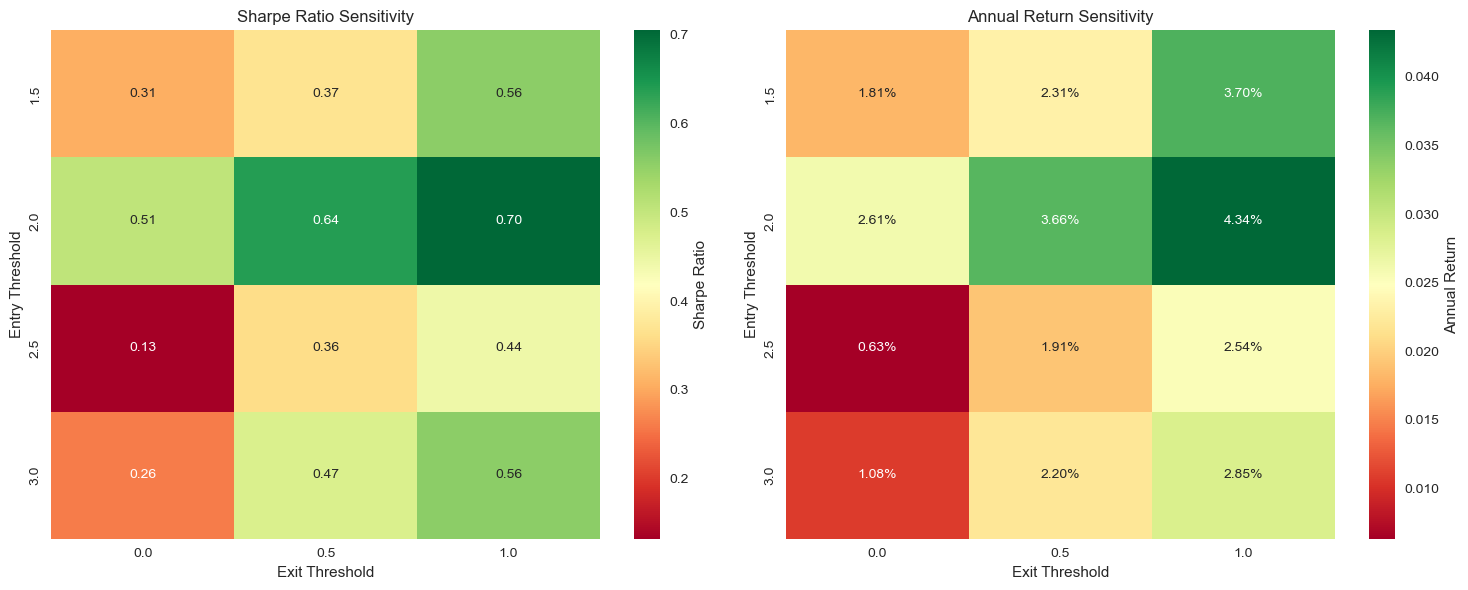


🏆 Best Parameters (by Sharpe):
Entry: 2.0
Exit: 1.0
Sharpe: 0.70
Annual Return: 4.34%
Max Drawdown: $96,079

📈 Current vs Best:
Current Sharpe: 0.51
Best Sharpe: 0.70
Improvement: 0.20


In [23]:
# Sensitivity Analysis - Parameter Robustness
print("🔍 Running sensitivity analysis...")

def grid_search_sharpe(prices: pd.DataFrame, beta: float, z: pd.Series,
                       entries=(1.5, 2.0, 2.5, 3.0), exits=(0.0, 0.5, 1.0)):
    """Grid search over entry/exit parameters to test robustness"""
    rows = []
    for e in entries:
        for x in exits:
            sig = generate_signals(z, entry=e, exit=x,
                                   max_abs_z=CONFIG["strategy"]["max_abs_z"],
                                   cooldown=CONFIG["strategy"]["cooldown"])
            bt = PairsBacktester(**CONFIG["execution"]).simulate(prices, sig, beta)
            s = sharpe_ratio(bt["pnl"], capital=CONFIG["execution"]["capital"])
            ann_ret = annual_return(bt["pnl"], capital=CONFIG["execution"]["capital"])
            max_dd = max_drawdown(bt["equity"])
            rows.append({
                "entry": e, 
                "exit": x, 
                "sharpe": s,
                "annual_return": ann_ret,
                "max_drawdown": max_dd
            })
    return pd.DataFrame(rows)

# Run grid search
grid_results = grid_search_sharpe(prices, eg_result.beta, z_scores)

# Display results
print("\n📊 Parameter Sensitivity Results:")
print("=" * 80)
print(f"{'Entry':<8} {'Exit':<8} {'Sharpe':<8} {'Ann Ret':<10} {'Max DD':<12} {'Score'}")
print("=" * 80)

for _, row in grid_results.iterrows():
    # Simple scoring: Sharpe > 0.5, positive return, reasonable drawdown
    score = "✅" if (row["sharpe"] > 0.5 and row["annual_return"] > 0 and abs(row["max_drawdown"]) < cap*0.15) else "❌"
    print(f"{row['entry']:<8.1f} {row['exit']:<8.1f} {row['sharpe']:<8.2f} {row['annual_return']:<10.2%} ${abs(row['max_drawdown']):<11,.0f} {score}")

print("=" * 80)
print("✅ = Good performance, ❌ = Poor performance")

# Visualize sensitivity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Sharpe heatmap
sharpe_pivot = grid_results.pivot(index="entry", columns="exit", values="sharpe")
sns.heatmap(sharpe_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, 
            cbar_kws={'label': 'Sharpe Ratio'})
ax1.set_title("Sharpe Ratio Sensitivity")
ax1.set_xlabel("Exit Threshold")
ax1.set_ylabel("Entry Threshold")

# Annual return heatmap
ret_pivot = grid_results.pivot(index="entry", columns="exit", values="annual_return")
sns.heatmap(ret_pivot, annot=True, fmt='.2%', cmap='RdYlGn', ax=ax2,
            cbar_kws={'label': 'Annual Return'})
ax2.set_title("Annual Return Sensitivity")
ax2.set_xlabel("Exit Threshold")
ax2.set_ylabel("Entry Threshold")

plt.tight_layout()
plt.show()

# Find best parameters
best_idx = grid_results["sharpe"].idxmax()
best_params = grid_results.loc[best_idx]

print(f"\n🏆 Best Parameters (by Sharpe):")
print(f"Entry: {best_params['entry']:.1f}")
print(f"Exit: {best_params['exit']:.1f}")
print(f"Sharpe: {best_params['sharpe']:.2f}")
print(f"Annual Return: {best_params['annual_return']:.2%}")
print(f"Max Drawdown: ${abs(best_params['max_drawdown']):,.0f}")

# Compare with current parameters
current_sharpe = sharpe
print(f"\n📈 Current vs Best:")
print(f"Current Sharpe: {current_sharpe:.2f}")
print(f"Best Sharpe: {best_params['sharpe']:.2f}")
print(f"Improvement: {best_params['sharpe'] - current_sharpe:.2f}")


## Visual Diagnostics

- **Z-score panel**: are entries/exits sensible or too chatty?  
- **Equity curve**: smooth mean-reversion or noisy / cost-dominated?  
- If equity looks like a trend strategy, re-check **delay** and signal logic.


In [25]:
# Final Summary and Conclusions
print("\n🎯 Strategy Summary & Conclusions")
print("=" * 60)

# Strategy assessment
if eg_result.pval < 0.05:
    coint_status = "✅ Cointegrated"
else:
    coint_status = "❌ Not cointegrated"

if sharpe > 1.0:
    performance_status = "✅ Excellent"
elif sharpe > 0.5:
    performance_status = "⚠️  Moderate"
else:
    performance_status = "❌ Poor"

print(f"Cointegration Status: {coint_status}")
print(f"Performance Rating: {performance_status}")
print(f"Strategy Viability: {'✅ Viable' if eg_result.pval < 0.05 and sharpe > 0.5 else '❌ Not viable'}")

print(f"\n📊 Key Insights:")
print(f"• Hedge ratio of {eg_result.beta:.3f} suggests {CONFIG['data']['ticker1']} is {'more' if eg_result.beta > 1 else 'less'} volatile than {CONFIG['data']['ticker2']}")
print(f"• R² of {eg_result.r2:.3f} indicates {'strong' if eg_result.r2 > 0.8 else 'moderate' if eg_result.r2 > 0.5 else 'weak'} linear relationship")
print(f"• Strategy generated {(signals != 0).sum()} trading signals over {len(signals)} days")
print(f"• Total costs of ${total_costs + total_borrow:,.0f} represent {abs(total_costs + total_borrow) / abs(total_pnl) * 100:.1f}% of gross PnL")

print(f"\n⚠️  Important Limitations:")
print(f"• Results are based on historical data and may not predict future performance")
print(f"• Transaction costs and slippage are simplified estimates")
print(f"• No consideration of market impact or liquidity constraints")
print(f"• Cointegration relationships can break down over time")

print(f"\n🚀 Next Steps for Improvement:")
print(f"• Test on out-of-sample data to validate robustness")
print(f"• Implement dynamic hedge ratio estimation (Kalman filter)")
print(f"• Add risk management overlays (position sizing, drawdown limits)")
print(f"• Consider multiple pairs for portfolio diversification")
print(f"• Implement more sophisticated execution models")

print("\n" + "=" * 60)
print("📚 This analysis demonstrates the complete pairs trading workflow")
print("   from cointegration testing to performance evaluation.")
print("   Use this as a foundation for further research and development.")
print("=" * 60)



🎯 Strategy Summary & Conclusions
Cointegration Status: ✅ Cointegrated
Performance Rating: ⚠️  Moderate
Strategy Viability: ✅ Viable

📊 Key Insights:
• Hedge ratio of 0.830 suggests XOM is less volatile than CVX
• R² of 0.923 indicates strong linear relationship
• Strategy generated 881 trading signals over 2009 days
• Total costs of $23,488 represent 11.3% of gross PnL

⚠️  Important Limitations:
• Results are based on historical data and may not predict future performance
• Transaction costs and slippage are simplified estimates
• No consideration of market impact or liquidity constraints
• Cointegration relationships can break down over time

🚀 Next Steps for Improvement:
• Test on out-of-sample data to validate robustness
• Implement dynamic hedge ratio estimation (Kalman filter)
• Add risk management overlays (position sizing, drawdown limits)
• Consider multiple pairs for portfolio diversification
• Implement more sophisticated execution models

📚 This analysis demonstrates the c

## Sensitivity — Avoid brittle settings

We grid over entry/exit to see if performance is **robust**.  
If good metrics occur only at a razor-thin combo (e.g., entry=2.1, exit=0.05), beware **overfitting**.



🔍 Trade-by-Trade Analysis
Total trades: 67
Average trade duration: 29.7 days
Average trade PnL: $4,627
Win rate: 64.2%
Best trade: $56,441
Worst trade: $-41,459


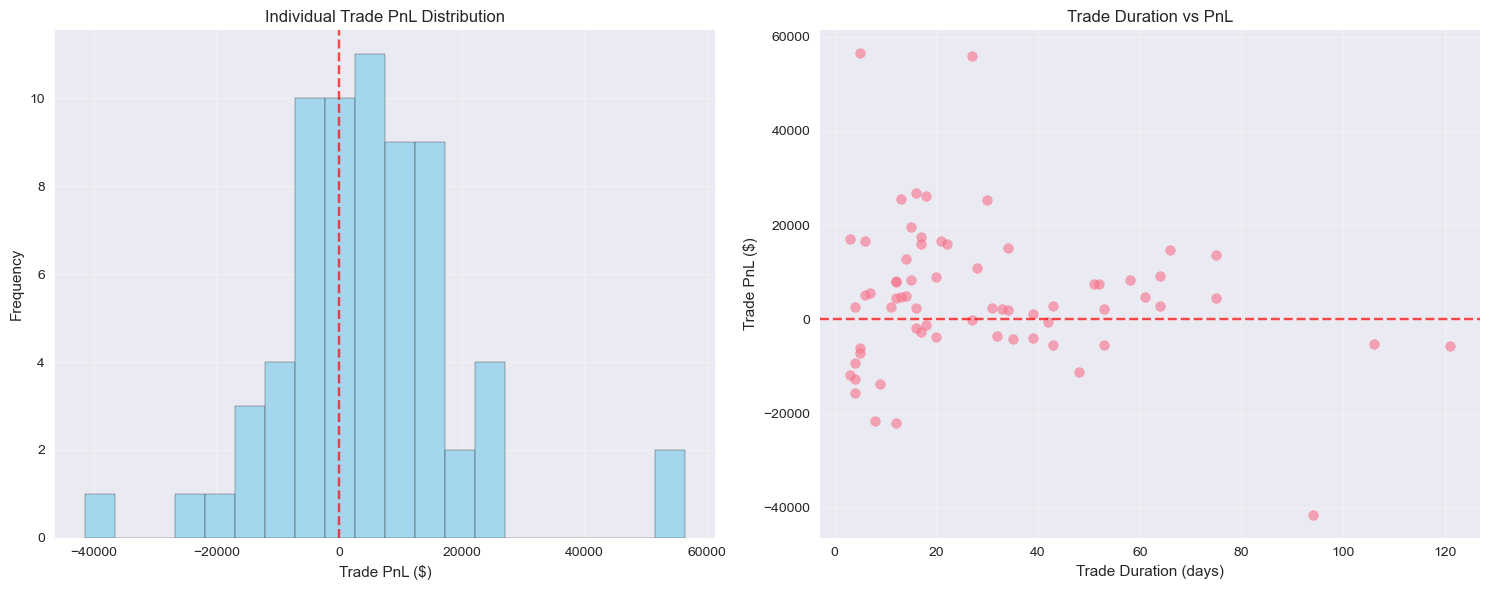

In [27]:
# Additional Analysis: Trade-by-Trade Breakdown
print("\n🔍 Trade-by-Trade Analysis")
print("=" * 50)

# Identify trade periods
signal_changes = signals.diff().fillna(0)
trade_starts = signal_changes[signal_changes != 0].index
trade_periods = []

for i, start_date in enumerate(trade_starts):
    if i < len(trade_starts) - 1:
        end_date = trade_starts[i + 1]
    else:
        end_date = signals.index[-1]
    
    period_signals = signals.loc[start_date:end_date]
    if len(period_signals) > 1:  # Only consider periods with actual trades
        trade_periods.append({
            'start': start_date,
            'end': end_date,
            'signal': period_signals.iloc[0],
            'duration': len(period_signals),
            'pnl': results['pnl'].loc[start_date:end_date].sum()
        })

trades_df = pd.DataFrame(trade_periods)

if len(trades_df) > 0:
    print(f"Total trades: {len(trades_df)}")
    print(f"Average trade duration: {trades_df['duration'].mean():.1f} days")
    print(f"Average trade PnL: ${trades_df['pnl'].mean():,.0f}")
    print(f"Win rate: {(trades_df['pnl'] > 0).mean():.1%}")
    print(f"Best trade: ${trades_df['pnl'].max():,.0f}")
    print(f"Worst trade: ${trades_df['pnl'].min():,.0f}")
    
    # Trade distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Trade PnL distribution
    trades_df['pnl'].hist(bins=20, ax=ax1, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title("Individual Trade PnL Distribution")
    ax1.set_xlabel("Trade PnL ($)")
    ax1.set_ylabel("Frequency")
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    ax1.grid(True, alpha=0.3)
    
    # Trade duration vs PnL
    ax2.scatter(trades_df['duration'], trades_df['pnl'], alpha=0.6, s=50)
    ax2.set_title("Trade Duration vs PnL")
    ax2.set_xlabel("Trade Duration (days)")
    ax2.set_ylabel("Trade PnL ($)")
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No complete trades found in the analysis period.")

print("\n" + "=" * 50)


## Limitations & Next Experiments

**Limitations**
- Daily close data; intra-day microstructure ignored.
- Costs are simplified bps; real fills vary with liquidity/venue.
- Borrow availability/rates vary; we use a flat APR.
- Cointegration can **break**; this is not a proof of future mean-reversion.
- Universe selection may have **survivorship bias**.

**Next Experiments**
- **Rolling β** (expanding OLS) or **Kalman filter**; re-test EG on a rolling basis.
- Johansen test (multivariate cointegration).
- Universe scan + **IS/OOS** split; avoid tuning on the same sample you score.
- Risk overlays: **vol targeting**, **drawdown stops**, **max gross**.
- Execution realism: delayed exits, partial fills, bar-close/next-open fills.


## 🎓 Educational Notes

### Key Concepts Demonstrated

1. **Cointegration Testing**: Engle-Granger 2-step procedure to identify mean-reverting relationships
2. **Hedge Ratio Estimation**: OLS regression to determine optimal hedge ratio
3. **Signal Generation**: Z-score based entry/exit rules with hysteresis
4. **Realistic Backtesting**: Transaction costs, slippage, borrow fees, and signal delays
5. **Performance Evaluation**: Multiple risk-adjusted metrics and visualizations
6. **Sensitivity Analysis**: Parameter robustness testing to avoid overfitting

### Mathematical Foundations

- **Spread**: $S_t = A_t - \beta B_t$
- **Z-Score**: $Z_t = \frac{S_t - \mu_t}{\sigma_t}$
- **Sharpe Ratio**: $\frac{\mu_r}{\sigma_r} \sqrt{252}$
- **Sortino Ratio**: $\frac{\mu_r}{\sigma_{down}} \sqrt{252}$

### Best Practices Shown

- ✅ **No look-ahead bias**: Signal delay implementation
- ✅ **Realistic costs**: Transaction costs and borrow fees
- ✅ **Risk management**: Emergency stops and cooldown periods
- ✅ **Robustness testing**: Parameter sensitivity analysis
- ✅ **Comprehensive evaluation**: Multiple performance metrics

### Next Steps for Advanced Implementation

1. **Dynamic Hedge Ratios**: Kalman filter or rolling regression
2. **Portfolio Approach**: Multiple pairs with correlation analysis
3. **Risk Overlays**: Position sizing, drawdown limits, volatility targeting
4. **Execution Models**: Market impact, partial fills, latency simulation
5. **Out-of-Sample Testing**: Walk-forward analysis and cross-validation

---

**Remember**: This is an educational demonstration. Real trading involves additional complexities including market impact, liquidity constraints, regulatory requirements, and operational risks.
